In [1]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
import numpy as np
from tqdm.notebook import tqdm

In [2]:
with open('data/bible.txt', 'r', encoding='utf-8') as f:
    data = f.read()

n = len(data)

print(n)

train_data = data[:int(n*0.9)]
test_data = data[int(n*0.9):]

# encode with tiktoken gpt2 bpe
enc = tiktoken.get_encoding("gpt2")
train_ids = enc.encode(train_data)
test_ids = enc.encode(test_data)
print(f"train has {len(train_ids):,} tokens")
print(f"test has {len(test_ids):,} tokens")

# export to bin files
train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

4351186
train has 1,087,091 tokens
test has 117,911 tokens


## Transformer Architecture

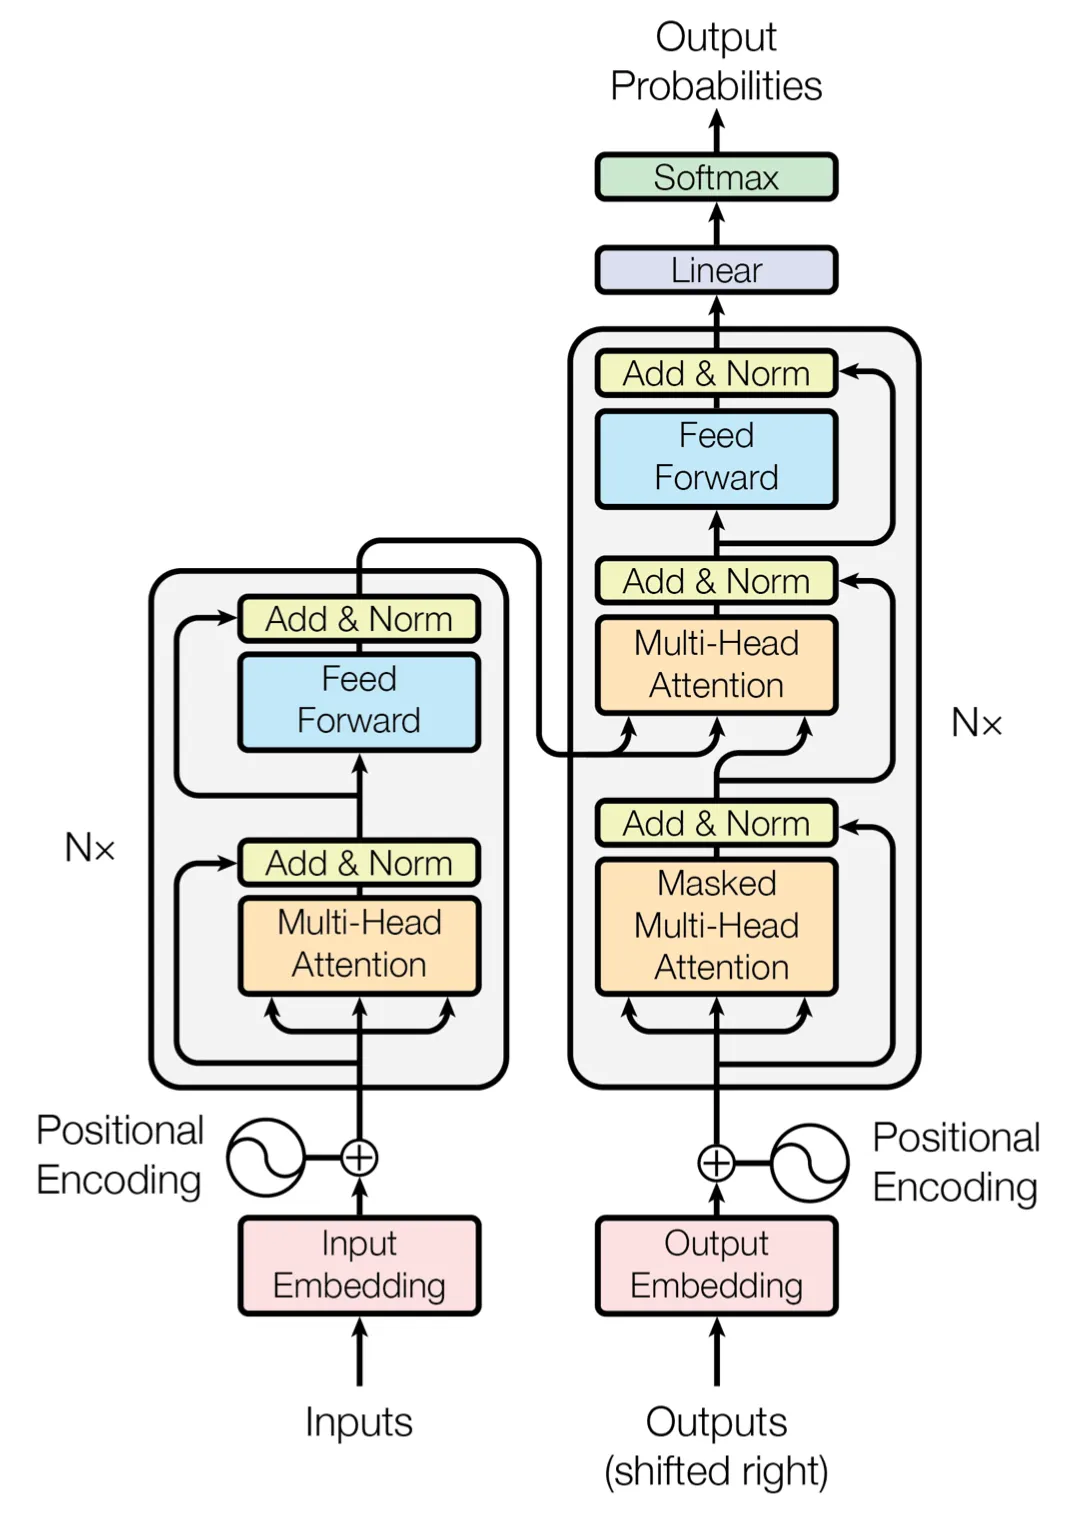

In [3]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py

Change to the original implementation:
https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
"""

block_size = 512
vocab_size = 50257 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
n_layer = 8
n_head = 8
n_embd = 768
dropout = 0.1
bias = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
learning_rate = 1e-3
weight_decay = 1e-1
batch_size = 8


class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(n_embd))
        self.bias = nn.Parameter(torch.zeros(n_embd)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.attn = MultiHeadAttention(n_head, head_size)
        self.mlp = MLP()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class GPT(nn.Module):
    def __init__(self):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block() for _ in range(n_layer)]),
            ln_f = LayerNorm(),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

model = GPT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# start with all of the candidate parameters
param_dict = {pn: p for pn, p in model.named_parameters()}
# filter out those that do not require grad
param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
# create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
# i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': decay_params, 'weight_decay': weight_decay},
    {'params': nodecay_params, 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95))

In [4]:
max_steps = 500
current_position = 0

new_phrase = "And God said"
new_phrase_ids = enc.encode_ordinary(new_phrase)
new_phrase_ids = torch.tensor(new_phrase_ids).unsqueeze(0).to(device)

for step in tqdm(range(max_steps + 1)):
    buf = train_ids[current_position : current_position+(batch_size*block_size)+1]
    X = (buf[:-1]).view(batch_size, block_size) # inputs
    y = (buf[1:]).view(batch_size, block_size) # targets
    # advance the position in the tensor
    current_position += batch_size * block_size
    # if loading the next batch would be out of bounds, advance to next shard
    if current_position + (batch_size * block_size + 1) > len(train_ids):
        current_position = 0

    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    logits, loss = model(X, y)

    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        # Test model on text
        out = model.generate(new_phrase_ids, 20, temperature=1.0, top_k=None)
        out = list(out.squeeze())
        out = enc.decode(out)
        print(f"Loss: {loss.item()}")
        print(f"Step: {step} - {out}")


  0%|          | 0/501 [00:00<?, ?it/s]

Loss: 10.911867141723633
Step: 0 - And God said Ink ones communicated elliptPM PTSD Dirtepabytes › Defence Region� tv Tru Voy 520 partakeOrangeNear
Loss: 5.995213985443115
Step: 50 - And God said you oil: our the At Israel said Neither God thisnefort their23
 inled itwild
Loss: 5.618402481079102
Step: 100 - And God saida, Israel in
49re unto go: Had battle there, a of each Yet forline
Loss: 5.406100273132324
Step: 150 - And God said of sett valuedency:49 my good them, which he high My drawn, the soul multiplied mighty
Loss: 5.333164215087891
Step: 200 - And God saiduted of it ofto their thee came to done as as sheek as
 Ben for take upon
Loss: 4.772556304931641
Step: 250 - And God said thou teeth, whichareth was

9 But there found, upon the victory, let him,
Loss: 4.738035202026367
Step: 300 - And God said noath utter continually, thy

33 Thou shall she at the priests torn upon the LORD which
Loss: 4.607804298400879
Step: 350 - And God said unto all the hill was the king of when thou t